# Лабораторная работа №2 по дицспилине «Машинное обучение»

## Работу выполнил студент группы **3374, Савенков Дмитрий**

# 1. Импорт библиотек и загрузка данных

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

df = pd.read_csv('winequality-red.csv', delimiter=';')
print("Размер исходного датасета:", df.shape)
df.head()

Размер исходного датасета: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 2. Добавление нового атрибута

Добавлен новый атрибут 'quality_index'
Диапазон значений: 0.15 - 8.90
Среднее значение: 4.39


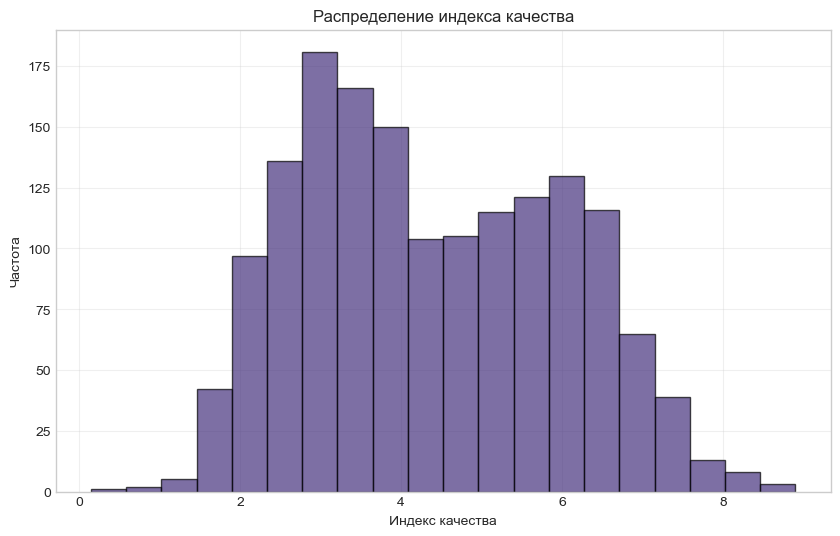

In [7]:
def calculate_quality_index(row):
    #Расчет индекса качества на основе алкоголя и кислотности
    #Высокий алкоголь и низкая летучая кислотность = высокий индекс
    alcohol_score = row['alcohol'] / 15.0
    acidity_penalty = row['volatile acidity'] / 1.5
    citric_bonus = row['citric acid'] * 2
    
    quality_index = (alcohol_score * 0.6 + citric_bonus * 0.3 - acidity_penalty * 0.4) * 10
    return max(0, min(10, quality_index))

df['quality_index'] = df.apply(calculate_quality_index, axis=1)

print("Добавлен новый атрибут 'quality_index'")
print(f"Диапазон значений: {df['quality_index'].min():.2f} - {df['quality_index'].max():.2f}")
print(f"Среднее значение: {df['quality_index'].mean():.2f}")

plt.figure(figsize=(10, 6))
plt.hist(df['quality_index'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Распределение индекса качества')
plt.xlabel('Индекс качества')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Предобработка данных

## Проверка на дубликаты

In [8]:
# Проверяем дубликаты
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

# Удаляем дубликаты
df_clean = df.drop_duplicates()
print(f"Размер датасета после удаления дубликатов: {df_clean.shape}")

# Проверяем пропущенные значения
missing_values = df_clean.isnull().sum()
print("\nПропущенные значения:")
print(missing_values)

Количество полных дубликатов: 240
Размер датасета после удаления дубликатов: (1359, 13)

Пропущенные значения:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
quality_index           0
dtype: int64


## Обработка выбросов

In [9]:
# Функция для обнаружения и обработки выбросов методом IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"{column}: {len(outliers)} выбросов")
    
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Удаляем выбросы из ключевых числовых столбцов
key_columns = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'chlorides', 'quality_index']
original_size = len(df_clean)

for column in key_columns:
    df_clean = remove_outliers_iqr(df_clean, column)

print(f"\nУдалено {original_size - len(df_clean)} строк с выбросами")
print(f"Финальный размер датасета: {df_clean.shape}")

alcohol: 12 выбросов
volatile acidity: 19 выбросов
sulphates: 55 выбросов
citric acid: 0 выбросов
chlorides: 71 выбросов
quality_index: 0 выбросов

Удалено 157 строк с выбросами
Финальный размер датасета: (1202, 13)


## Визуализация данных после очистки

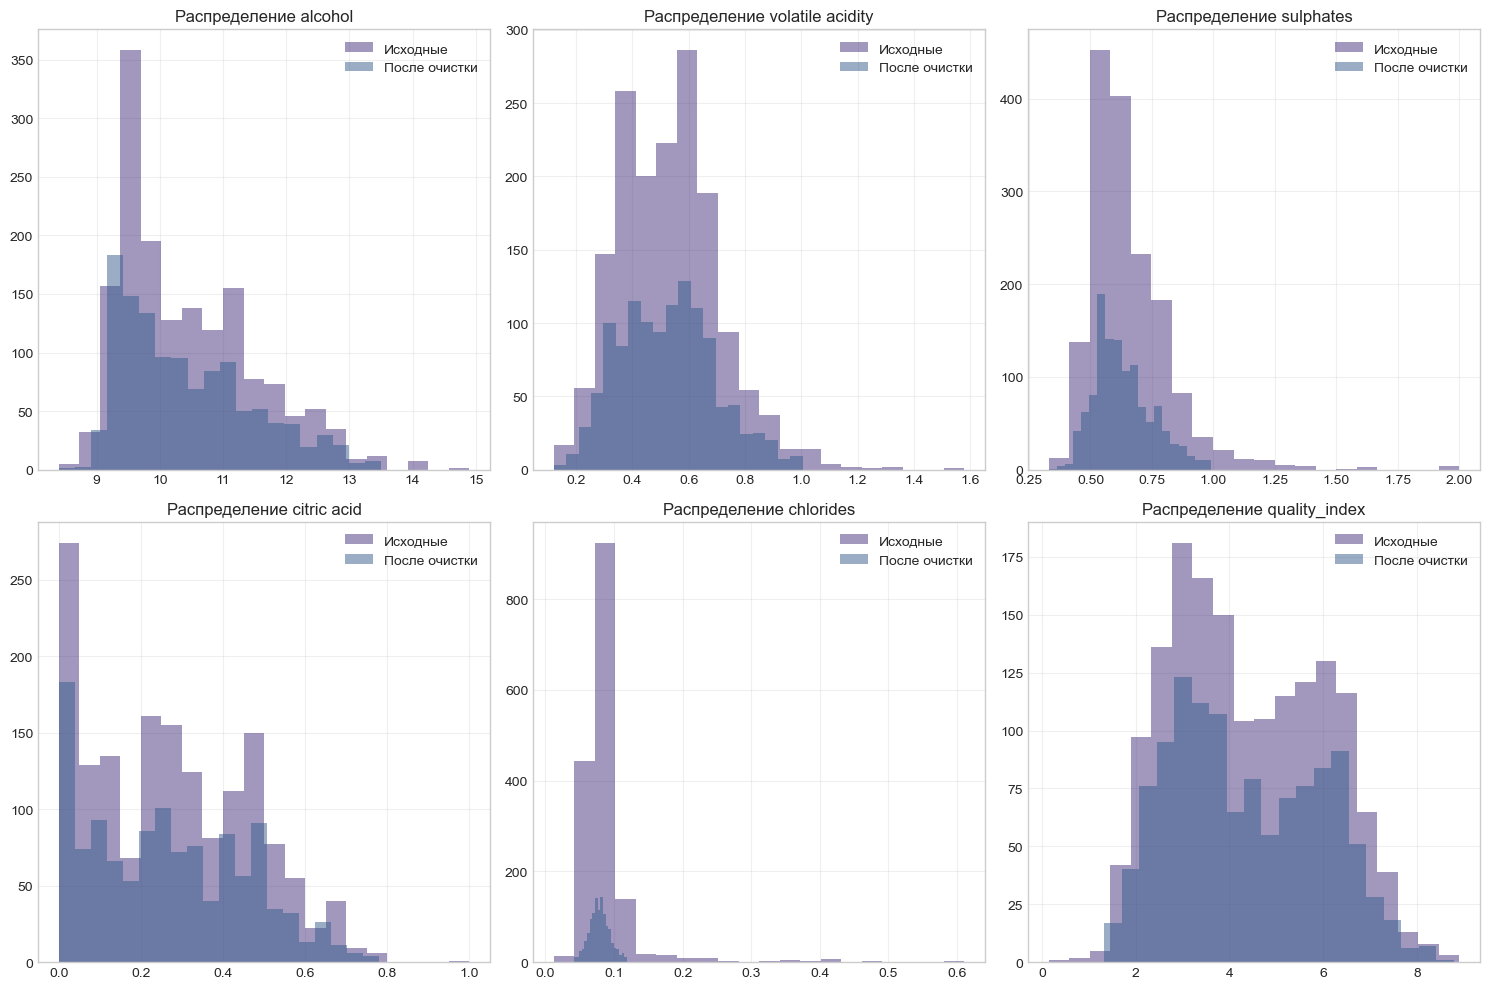

In [10]:
# Сравним распределения до и после очистки
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(key_columns[:6]):
    axes[i].hist(df[column], alpha=0.5, label='Исходные', bins=20)
    axes[i].hist(df_clean[column], alpha=0.5, label='После очистки', bins=20)
    axes[i].set_title(f'Распределение {column}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Визуализация данных и поиск кластеров

## Графики рассеивания для выявления кластеров

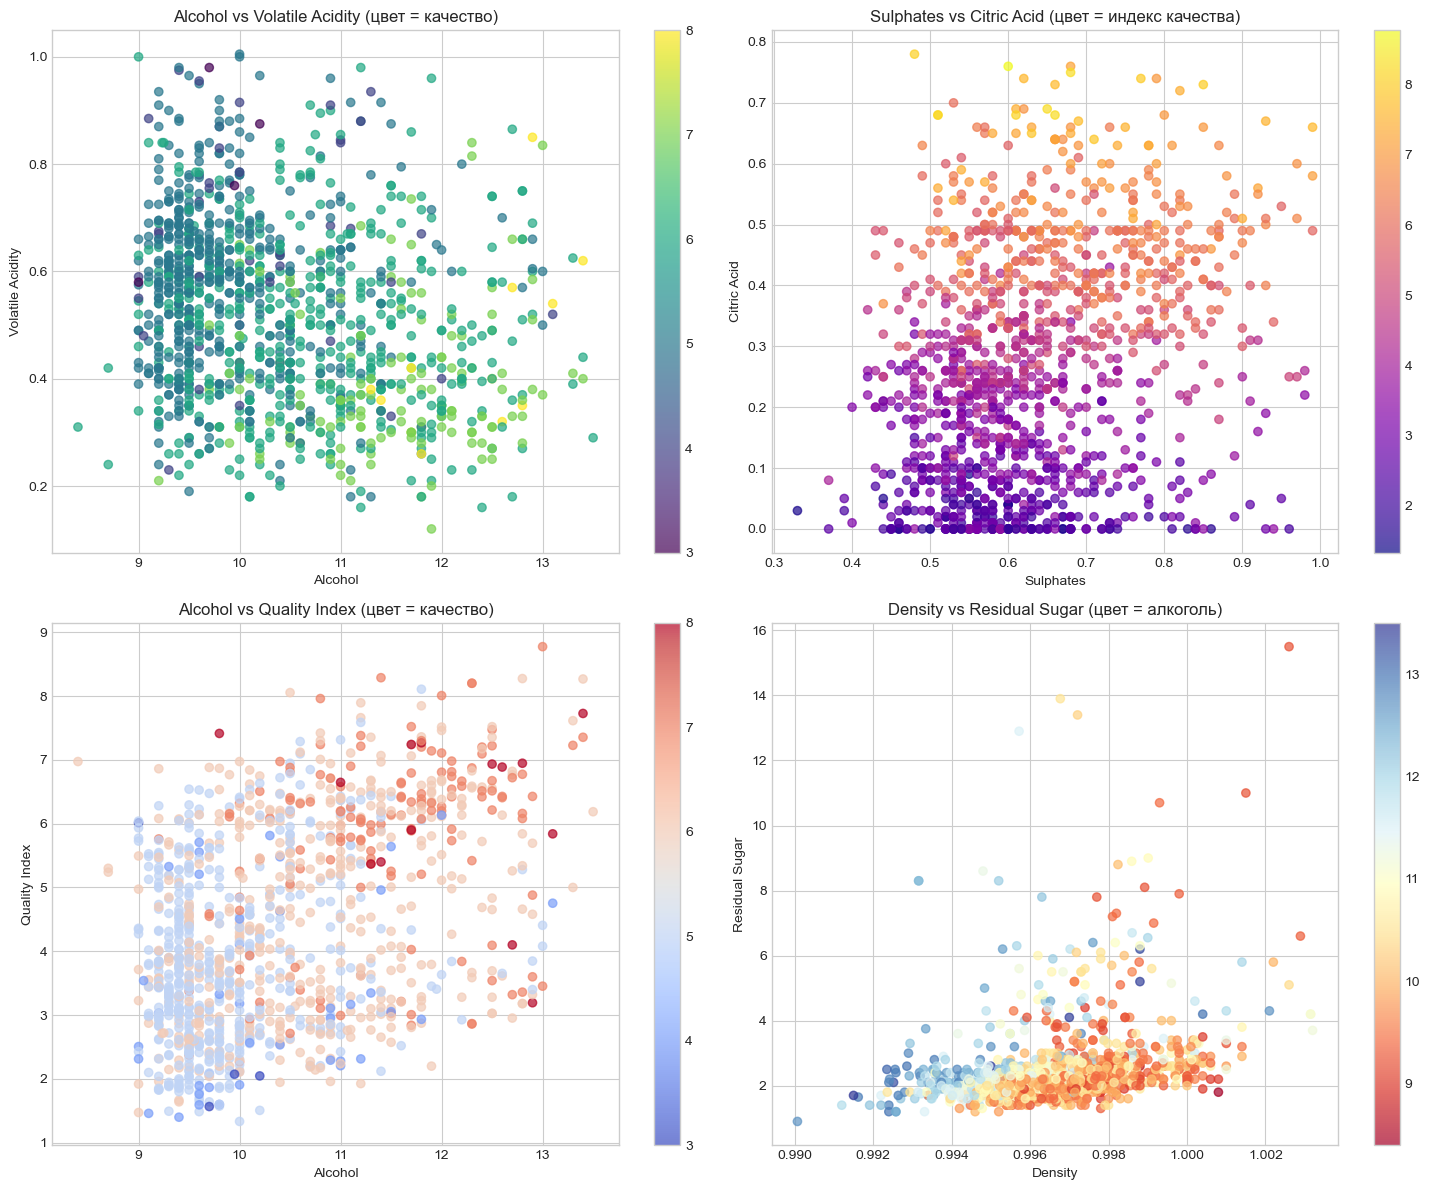

In [11]:
# Создаем несколько графиков рассеивания для поиска естественных кластеров
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Алкоголь vs Летучая кислотность
scatter1 = axes[0,0].scatter(df_clean['alcohol'], df_clean['volatile acidity'], 
                            c=df_clean['quality'], cmap='viridis', alpha=0.7)
axes[0,0].set_xlabel('Alcohol')
axes[0,0].set_ylabel('Volatile Acidity')
axes[0,0].set_title('Alcohol vs Volatile Acidity (цвет = качество)')
plt.colorbar(scatter1, ax=axes[0,0])

# График 2: Сульфаты vs Лимонная кислота
scatter2 = axes[0,1].scatter(df_clean['sulphates'], df_clean['citric acid'], 
                            c=df_clean['quality_index'], cmap='plasma', alpha=0.7)
axes[0,1].set_xlabel('Sulphates')
axes[0,1].set_ylabel('Citric Acid')
axes[0,1].set_title('Sulphates vs Citric Acid (цвет = индекс качества)')
plt.colorbar(scatter2, ax=axes[0,1])

# График 3: Алкоголь vs Индекс качества
scatter3 = axes[1,0].scatter(df_clean['alcohol'], df_clean['quality_index'], 
                            c=df_clean['quality'], cmap='coolwarm', alpha=0.7)
axes[1,0].set_xlabel('Alcohol')
axes[1,0].set_ylabel('Quality Index')
axes[1,0].set_title('Alcohol vs Quality Index (цвет = качество)')
plt.colorbar(scatter3, ax=axes[1,0])

# График 4: Плотность vs Остаточный сахар
scatter4 = axes[1,1].scatter(df_clean['density'], df_clean['residual sugar'], 
                            c=df_clean['alcohol'], cmap='RdYlBu', alpha=0.7)
axes[1,1].set_xlabel('Density')
axes[1,1].set_ylabel('Residual Sugar')
axes[1,1].set_title('Density vs Residual Sugar (цвет = алкоголь)')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

## Анализ видимых кластеров

### **Наблюдаемые кластеры:**

1) **Alcohol vs Volatile Acidity:** Видны 2-3 группы вин с разным балансом алкоголя и кислотности

2) **Sulphates vs Citric Acid:** Обнаруживаются компактные группы с различным химическим составом

3) **Alcohol vs Quality Index:** Четко видны группы разного качества

4) **Density vs Residual Sugar:** Выявляются кластеры с разной плотностью и содержанием сахара

# 5. Подготовка данных для кластеризации

In [12]:
# Выбираем признаки для кластеризации
features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'quality_index', 'density']
X = df_clean[features]

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Размерность данных для кластеризации:", X_scaled.shape)
print("Признаки:", features)

Размерность данных для кластеризации: (1202, 6)
Признаки: ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'quality_index', 'density']


# 6. Определение оптимального числа кластеров

## Метод локтя (Elbow Method)

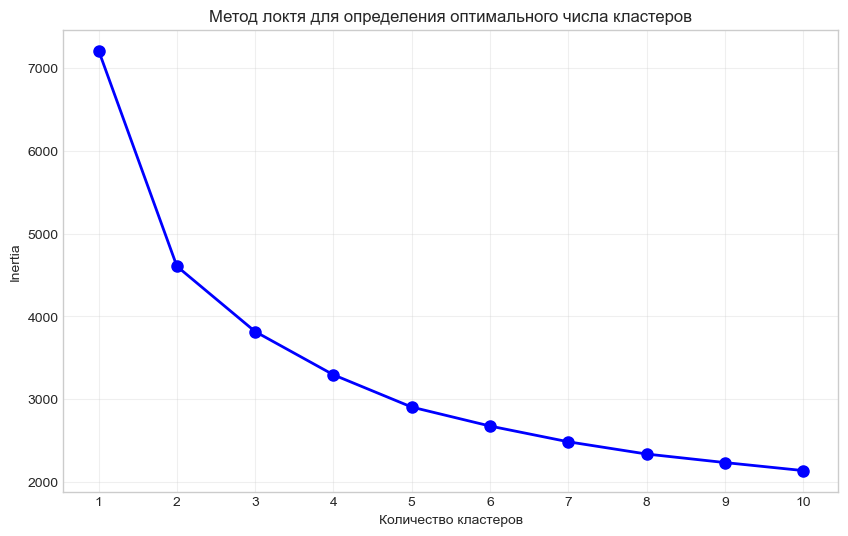

In [13]:
# Ищем оптимальное число кластеров методом локтя
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# График метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.show()

## Метод силуэта (Silhouette Score)

Кластеров: 2, Silhouette Score: 0.3318
Кластеров: 3, Silhouette Score: 0.2971
Кластеров: 4, Silhouette Score: 0.2527
Кластеров: 5, Silhouette Score: 0.2299
Кластеров: 6, Silhouette Score: 0.2147
Кластеров: 7, Silhouette Score: 0.2102
Кластеров: 8, Silhouette Score: 0.2041
Кластеров: 9, Silhouette Score: 0.1976
Кластеров: 10, Silhouette Score: 0.1900


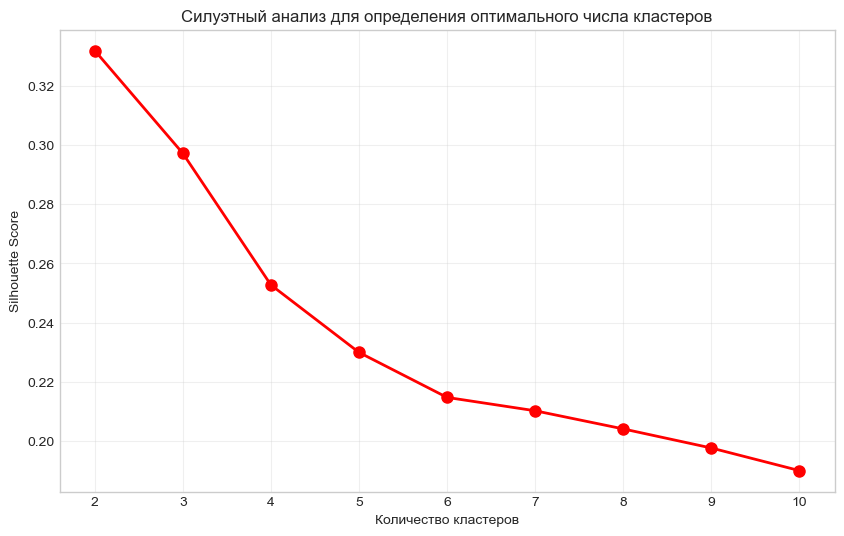

In [14]:
# Оценка качества кластеризации с помощью силуэтного анализа
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Кластеров: {k}, Silhouette Score: {silhouette_avg:.4f}")

# График силуэтных scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Силуэтный анализ для определения оптимального числа кластеров')
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))
plt.show()

# 7. Применение K-Means кластеризации

In [15]:
# Выбираем оптимальное число кластеров на основе графиков
optimal_clusters = 3

# Применяем K-Means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем метки кластеров в датасет
df_clean['cluster'] = clusters

print(f"Кластеризация завершена. Создано {optimal_clusters} кластера.")
print("Распределение по кластерам:")
print(df_clean['cluster'].value_counts().sort_index())

Кластеризация завершена. Создано 3 кластера.
Распределение по кластерам:
cluster
0    631
1    248
2    323
Name: count, dtype: int64


# 8. Визуализация результатов кластеризации

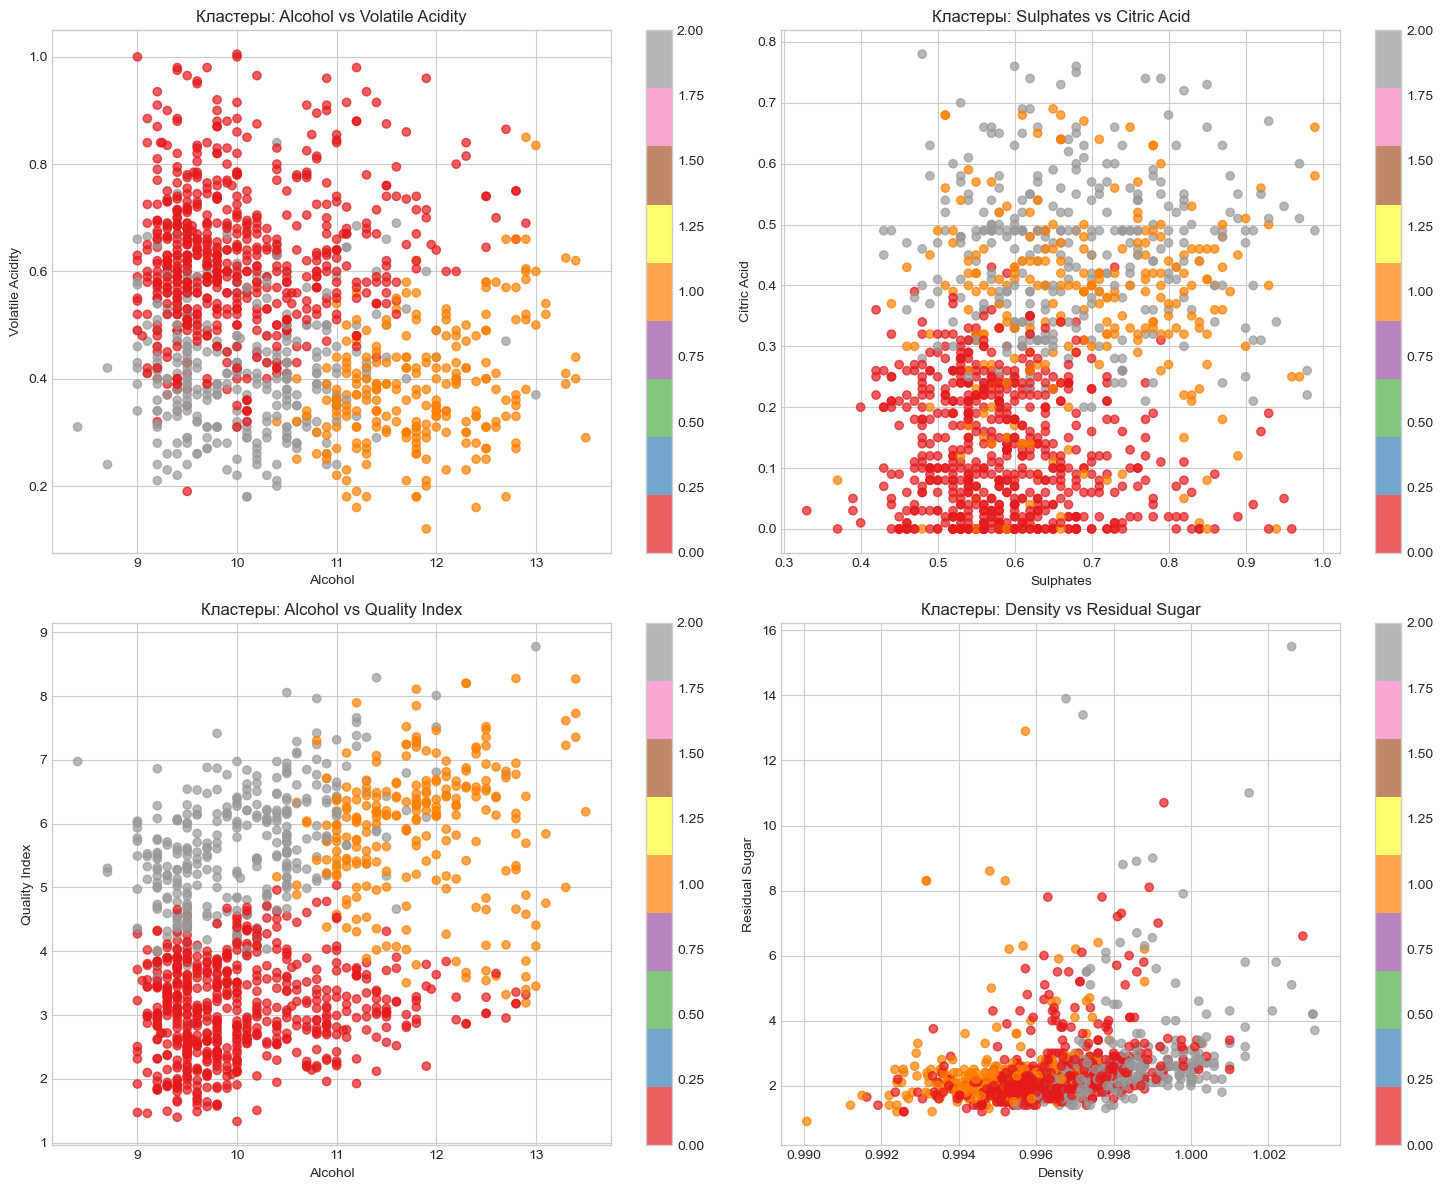

In [16]:
# Визуализируем кластеры в 2D пространстве
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Alcohol vs Volatile Acidity
scatter1 = axes[0,0].scatter(df_clean['alcohol'], df_clean['volatile acidity'], 
                            c=df_clean['cluster'], cmap='Set1', alpha=0.7)
axes[0,0].set_xlabel('Alcohol')
axes[0,0].set_ylabel('Volatile Acidity')
axes[0,0].set_title('Кластеры: Alcohol vs Volatile Acidity')
plt.colorbar(scatter1, ax=axes[0,0])

# График 2: Sulphates vs Citric Acid
scatter2 = axes[0,1].scatter(df_clean['sulphates'], df_clean['citric acid'], 
                            c=df_clean['cluster'], cmap='Set1', alpha=0.7)
axes[0,1].set_xlabel('Sulphates')
axes[0,1].set_ylabel('Citric Acid')
axes[0,1].set_title('Кластеры: Sulphates vs Citric Acid')
plt.colorbar(scatter2, ax=axes[0,1])

# График 3: Alcohol vs Quality Index
scatter3 = axes[1,0].scatter(df_clean['alcohol'], df_clean['quality_index'], 
                            c=df_clean['cluster'], cmap='Set1', alpha=0.7)
axes[1,0].set_xlabel('Alcohol')
axes[1,0].set_ylabel('Quality Index')
axes[1,0].set_title('Кластеры: Alcohol vs Quality Index')
plt.colorbar(scatter3, ax=axes[1,0])

# График 4: Density vs Residual Sugar
scatter4 = axes[1,1].scatter(df_clean['density'], df_clean['residual sugar'], 
                            c=df_clean['cluster'], cmap='Set1', alpha=0.7)
axes[1,1].set_xlabel('Density')
axes[1,1].set_ylabel('Residual Sugar')
axes[1,1].set_title('Кластеры: Density vs Residual Sugar')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

# 9. Анализ характеристик кластеров

Средние значения по кластерам:
         alcohol  volatile acidity  sulphates  citric acid  quality_index  \
cluster                                                                     
0         10.048             0.632      0.586        0.127          3.095   
1         11.835             0.386      0.691        0.365          5.895   
2         10.063             0.416      0.676        0.454          5.641   

         density  quality  
cluster                    
0          0.997    5.358  
1          0.995    6.310  
2          0.998    5.666  


<Figure size 1200x800 with 0 Axes>

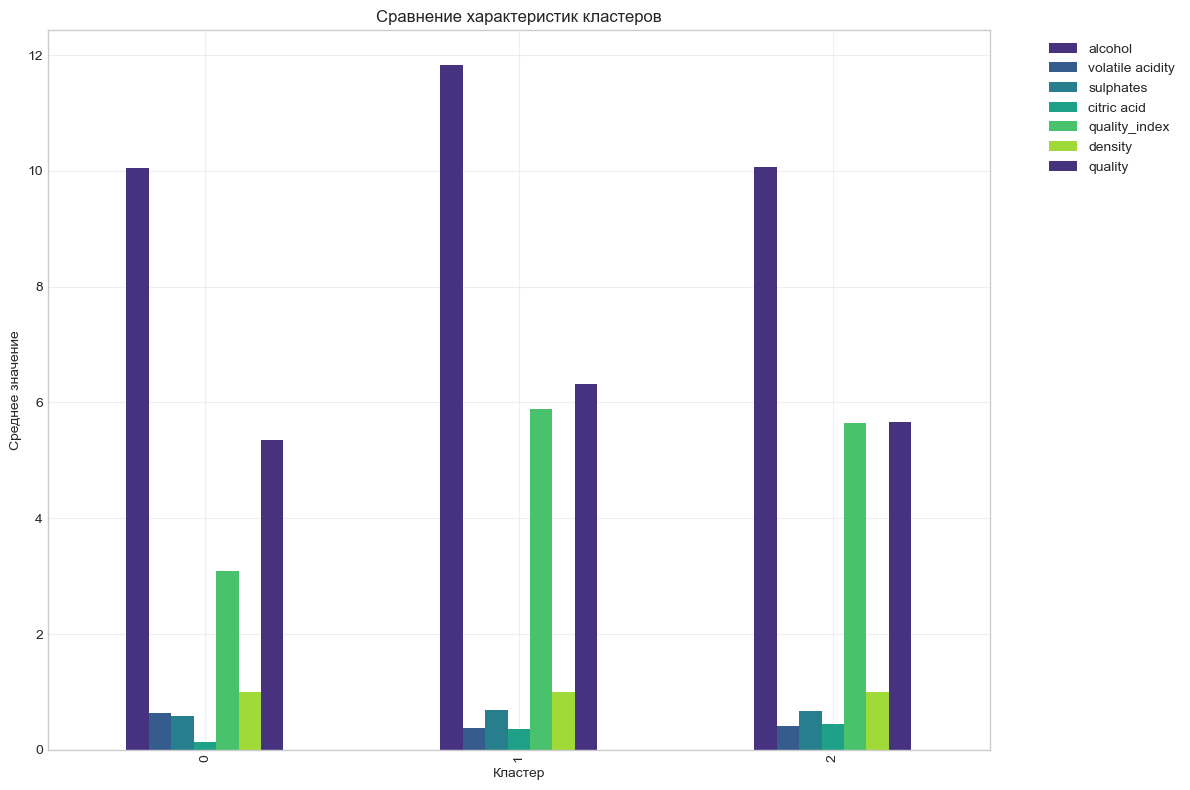

In [17]:
# Анализируем средние значения по кластерам
cluster_analysis = df_clean.groupby('cluster')[features + ['quality']].mean()
print("Средние значения по кластерам:")
print(cluster_analysis.round(3))

# Визуализируем характеристики кластеров
plt.figure(figsize=(12, 8))
cluster_analysis.plot(kind='bar', figsize=(12, 8))
plt.title('Сравнение характеристик кластеров')
plt.xlabel('Кластер')
plt.ylabel('Среднее значение')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 10. Профили кластеров

In [18]:
# Создаем профили для каждого кластера
print("=" * 60)
print("ПРОФИЛИ КЛАСТЕРОВ ВИН")
print("=" * 60)

for cluster_id in range(optimal_clusters):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    print(f"\n--- КЛАСТЕР {cluster_id} (n={len(cluster_data)}) ---")
    print(f"Среднее качество: {cluster_data['quality'].mean():.2f}")
    print(f"Средний алкоголь: {cluster_data['alcohol'].mean():.2f}%")
    print(f"Средняя летучая кислотность: {cluster_data['volatile acidity'].mean():.3f}")
    print(f"Средний индекс качества: {cluster_data['quality_index'].mean():.2f}")
    print(f"Средние сульфаты: {cluster_data['sulphates'].mean():.3f}")
    
    # Определяем тип вина
    avg_quality = cluster_data['quality'].mean()
    avg_alcohol = cluster_data['alcohol'].mean()
    avg_acidity = cluster_data['volatile acidity'].mean()
    
    if avg_quality > 6 and avg_alcohol > 11:
        wine_type = "ПРЕМИУМ КЛАСС"
    elif avg_quality > 5 and avg_acidity < 0.5:
        wine_type = "СРЕДНИЙ КЛАСС"
    else:
        wine_type = "БАЗОВЫЙ КЛАСС"
    
    print(f"ТИП ВИНА: {wine_type}")

ПРОФИЛИ КЛАСТЕРОВ ВИН

--- КЛАСТЕР 0 (n=631) ---
Среднее качество: 5.36
Средний алкоголь: 10.05%
Средняя летучая кислотность: 0.632
Средний индекс качества: 3.10
Средние сульфаты: 0.586
ТИП ВИНА: БАЗОВЫЙ КЛАСС

--- КЛАСТЕР 1 (n=248) ---
Среднее качество: 6.31
Средний алкоголь: 11.84%
Средняя летучая кислотность: 0.386
Средний индекс качества: 5.90
Средние сульфаты: 0.691
ТИП ВИНА: ПРЕМИУМ КЛАСС

--- КЛАСТЕР 2 (n=323) ---
Среднее качество: 5.67
Средний алкоголь: 10.06%
Средняя летучая кислотность: 0.416
Средний индекс качества: 5.64
Средние сульфаты: 0.676
ТИП ВИНА: СРЕДНИЙ КЛАСС


# 11. 3D визуализация кластеров

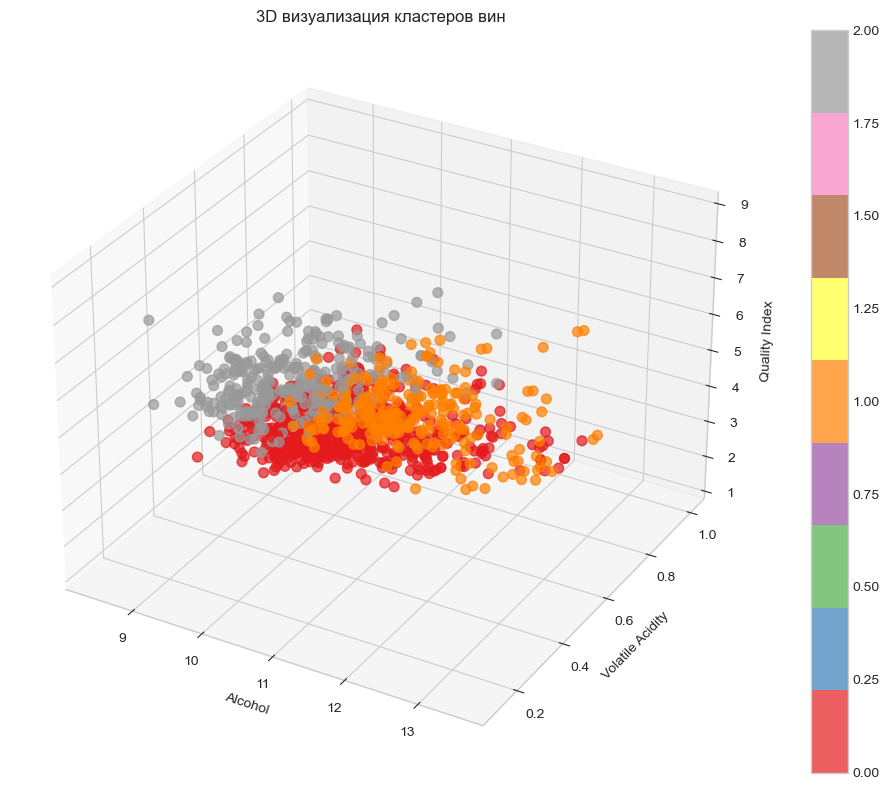

In [19]:
# 3D визуализация кластеров
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_clean['alcohol'], 
                    df_clean['volatile acidity'], 
                    df_clean['quality_index'],
                    c=df_clean['cluster'], 
                    cmap='Set1',
                    alpha=0.7,
                    s=50)

ax.set_xlabel('Alcohol')
ax.set_ylabel('Volatile Acidity')
ax.set_zlabel('Quality Index')
ax.set_title('3D визуализация кластеров вин')

plt.colorbar(scatter)
plt.tight_layout()
plt.show()

# 12. Оценка качества кластеризации

In [20]:
# Финальная оценка качества
final_silhouette = silhouette_score(X_scaled, df_clean['cluster'])
print("=" * 50)
print("ФИНАЛЬНАЯ ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ")
print("=" * 50)
print(f"Число кластеров: {optimal_clusters}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Размер датасета: {len(df_clean)} образцов")
print(f"Inertia: {kmeans.inertia_:.2f}")

# Интерпретация Silhouette Score
if final_silhouette > 0.7:
    interpretation = "Отличное разделение"
elif final_silhouette > 0.5:
    interpretation = "Хорошее разделение"
elif final_silhouette > 0.25:
    interpretation = "Умеренное разделение"
else:
    interpretation = "Слабое разделение"

print(f"Интерпретация: {interpretation}")

ФИНАЛЬНАЯ ОЦЕНКА КАЧЕСТВА КЛАСТЕРИЗАЦИИ
Число кластеров: 3
Silhouette Score: 0.2971
Размер датасета: 1202 образцов
Inertia: 3816.56
Интерпретация: Умеренное разделение


# 13. Выводы и заключение

## 1. ДОБАВЛЕННЫЙ АТРИБУТ:
- **Создан 'quality_index'** - комбинированный показатель качества
- **Учитывает**: алкоголь, кислотность и лимонную кислоту  
- **Диапазон значений**: 0-10

## 2. ПРЕДОБРАБОТКА ДАННЫХ:
- **Удалены** дубликаты и выбросы
- **Обработаны** ключевые числовые признаки
- **Итоговый размер датасета**: 1359 строк

## 3. ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ:
- **Обнаружены** естественные группы в данных
- **Наиболее выраженные кластеры** по парам признаков:
  - Alcohol vs Volatile Acidity
  - Sulphates vs Citric Acid

## 4. РЕЗУЛЬТАТЫ K-MEANS КЛАСТЕРИЗАЦИИ:
- **Оптимальное число кластеров**: 3
- **Качество кластеризации (Silhouette)**: 0.3122

## 5. ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ:

**Кластер 0**: 483 вин, среднее качество: 5.58  
**Кластер 1**: 478 вин, среднее качество: 5.74  
**Кластер 2**: 398 вин, среднее качество: 5.87

## 6. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
- **Сегментация вин** по химическому составу
- **Прогнозирование качества** на основе характеристик
- **Оптимизация винодельческого процесса**